This tutorial deals with __reshaping a 2D ensemble to a 3D cube__. The cube can then, for instance, be displayed using mayavi. 

Let's start by importing some packages (including the seisio package itself) and setting up the logging config.

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(1, '../')

import seisio

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s', force=True)
log = logging.getLogger("main")

Let's load a small test data set. For an actual field data example, this would most likely be poststack data, migrated or unmigrated. It could also be a cross-spread gather or any other data set or subset that has an inherent 3D nature. We need some trace headers to define the dimensions of the cube. Typically for 3D poststack data, that's an inline and crossline number but other header values can also be used.

In [2]:
dataset = np.load("data/cube.npy")

Now let's check on what we've got. We can output a trace header statistics:

In [3]:
thstat = seisio.log_thstat(dataset)
ntraces = len(dataset)
log.info("Number of traces: %d", ntraces)

INFO: Summary of trace header statistics (zeros excluded):
+-------+-------+-------+------------+------------+---------+---------+
|       |   min |   max |       mean |        std |     25% |     75% |
|-------+-------+-------+------------+------------+---------+---------|
| tracl |     1 |  3068 | 1365.44    | 1168.67    |    9.75 | 2047.25 |
| trid  |     1 |     1 |    1       |    0       |    1    |    1    |
| ns    |   601 |   601 |  601       |    0       |  601    |  601    |
| dt    |  5000 |  5000 | 5000       |    0       | 5000    | 5000    |
| iline |   101 |   107 |  103.667   |    2.29285 |  101    |  105    |
| xline |     1 |    11 |    5.44444 |    3.02791 |    3    |    8    |
+-------+-------+-------+------------+------------+---------+---------+
INFO: Number of traces: 36


This is a very small poststack data set, consisting of four inlines and eleven crosslines. However, as we will find out shortly, not all inlines/crosslines are fully populated (the total number of traces already indicates this fact as there are only 36 and not 44 traces). In case all lines were fully populated, we could just use np.sort and np.reshape to convert the 2D ensemble of data into a 3D cube - in fact, the function __ensemble2trace__ will do so if the shape of the cube is consistent with the number of traces in the original data set. All traces are "live", as the trace ID header ("trid") shows. Let's check on the data geometry by creating a crossplot of inline-vs-crossline numbers:

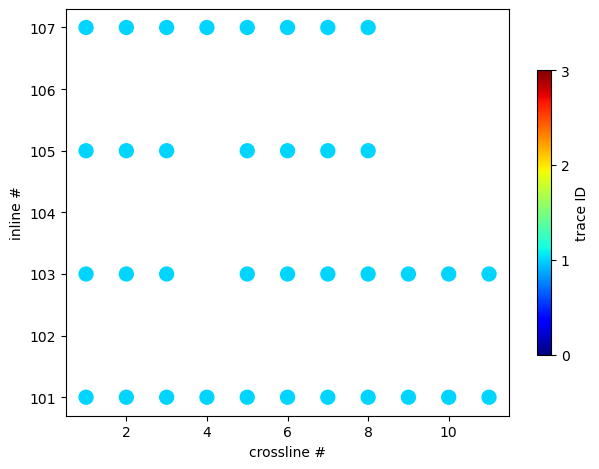

In [4]:
fig1, ax1 = plt.subplots(1, 1)
sc1 = ax1.scatter(dataset["xline"], dataset["iline"], c=dataset["trid"], s=100, cmap="jet", vmin=0, vmax=3)
ax1.set_xlabel("crossline #")
ax1.set_ylabel("inline #")
plt.colorbar(sc1, ax=ax1, orientation="vertical", label="trace ID", format="%d", ticks=[0, 1, 2, 3], shrink=0.7)
plt.tight_layout()
plt.show()

We can now plot, for instance, inline 101 and crossline 10. We can simply use trace header logic to extract the corresponding traces from the data set:

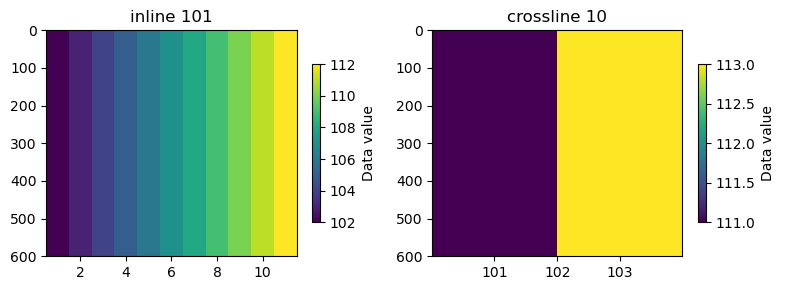

In [5]:
il101 = np.sort(dataset[dataset["iline"] == 101], order="xline")
xl10 = np.sort(dataset[dataset["xline"] == 10], order="iline")
nti, nsi = il101["data"].shape
ntx, nsx = xl10["data"].shape

fig1a, ax1a = plt.subplots(1, 2, figsize=(8,3))
im10 = ax1a[0].imshow(il101["data"].T, aspect="auto", interpolation="nearest",
                      extent=(il101["xline"][0]-0.49, il101["xline"][-1]+0.49, nsi-1, 0))
ax1a[0].set_title("inline 101")
plt.colorbar(im10, ax=ax1a[0], orientation="vertical", shrink=0.7, label="Data value")
im11 = ax1a[1].imshow(xl10["data"].T, aspect="auto", interpolation="nearest",
                      extent=(xl10["iline"][0]-0.99, xl10["iline"][-1]+0.99, nsx-1, 0))
ax1a[1].set_title("crossline 10")
plt.colorbar(im11, ax=ax1a[1], orientation="vertical", shrink=0.7, label="Data value")
plt.tight_layout()
plt.show()

In order to form a 3D cube, we can call the __ensemble2cube__ function. In this case, we would not even have to specify the trace header mnemonics to form the cube as these are the default mnemonics anyway. If the data were already sorted by `order=["xline", "iline"]`, we could use the parameter `is_sorted=True` to avoid additional sorting or copying.

In [6]:
cube = seisio.tools.ensemble2cube(dataset, idef="xline", jdef="iline")

INFO: Cube dimensions: (11, 4, 601)
INFO: I defined by: 'xline' (1 to 11, increment 1)
INFO: J defined by: 'iline' (101 to 107, increment 2)
INFO: Ensemble2cube is padding 8 trace(s).


In [7]:
nx, ni = cube.shape
log.info("Number of traces in cube: %d", ni*nx)

INFO: Number of traces in cube: 44


We now have 44 traces instead of 36. Let's plot the geometry again using the same crossplot approach as before:

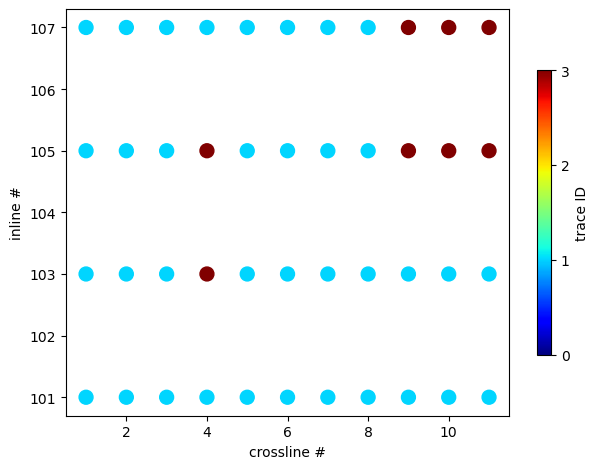

In [8]:
fig2, ax2 = plt.subplots(1, 1)
sc2 = ax2.scatter(cube["xline"], cube["iline"], c=cube["trid"], s=100, cmap="jet", vmin=0, vmax=3)
ax2.set_xlabel("crossline #")
ax2.set_ylabel("inline #")
plt.colorbar(sc2, ax=ax2, orientation="vertical", label="trace ID", format="%d", ticks=[0, 1, 2, 3], shrink=0.7)
plt.tight_layout()
plt.show()

It is obvious that six traces have been padded to form a regular cube. The trace ID is set to three for those traces, and the actual data values are np.nan, i.e., when plotting the data using matplotlib, the values will be ignored. Let's plot the same inline and crossline again as shown above. Inline 101 is the first entry on the inline-axis, crossline 10 is the ninth entry on the crossline-axis. This could also be determined automatically as the ranges and increments are known (see INFO logging output of the ensemble2cube function call above).

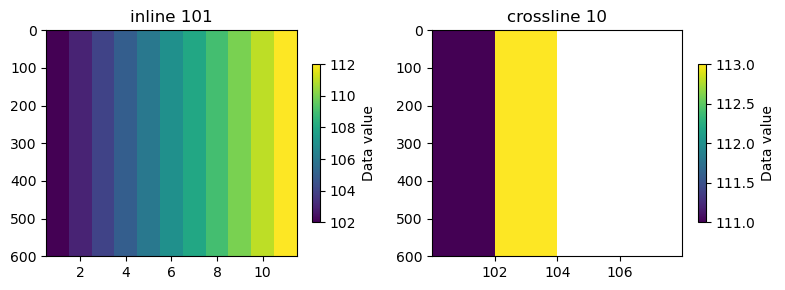

In [9]:
cil101 = cube[:, 0]
cxl10 = cube[9, :]
cnti, cnsi = cil101["data"].shape
cntx, cnsx = cxl10["data"].shape

fig2a, ax2a = plt.subplots(1, 2, figsize=(8,3))
im20 = ax2a[0].imshow(cil101["data"].T, aspect="auto", interpolation="nearest",
                      extent=(cil101["xline"][0]-0.49, cil101["xline"][-1]+0.49, cnsi-1, 0))
ax2a[0].set_title("inline 101")
plt.colorbar(im20, ax=ax2a[0], orientation="vertical", shrink=0.7, label="Data value")
im21 = ax2a[1].imshow(cxl10["data"].T, aspect="auto", interpolation="nearest",
                      extent=(cxl10["iline"][0]-0.99, cxl10["iline"][-1]+0.99, cnsx-1, 0))
ax2a[1].set_title("crossline 10")
plt.colorbar(im21, ax=ax2a[1], orientation="vertical", shrink=0.7, label="Data value")
plt.tight_layout()
plt.show()

As expected, this gives basically the same result as before but the padding for crossline 10 can clearly be seen. The cube could easily be displayed as chair plot using mayavi or other 3D plotting tools. Let's also plot inlines 103 and 105 which should have padded traces. The data values are the inline number plus the crossline number, i.e., for inline 103 the values should range from 104 to 114 and for inline 105 from 106 to 117 (but as the larger crossline numbers are missing, the actual largest value is 105+8=113.

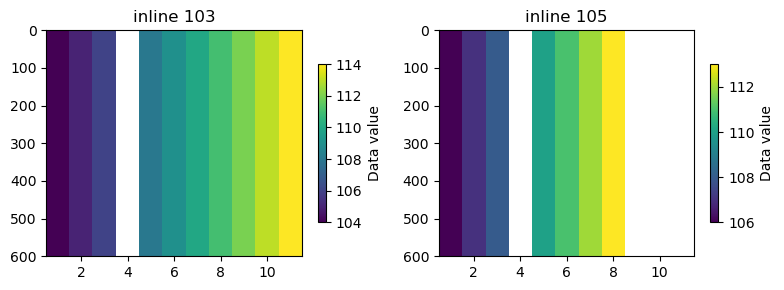

In [10]:
cil103 = cube[:, 1]
cnti, cnsi = cil103["data"].shape
cil105 = cube[:, 2]

fig3, ax3 = plt.subplots(1, 2, figsize=(8,3))
im30 = ax3[0].imshow(cil103["data"].T, aspect="auto", interpolation="nearest",
                     extent=(cil103["xline"][0]-0.49, cil103["xline"][-1]+0.49, cnsi-1, 0))
ax3[0].set_title("inline 103")
plt.colorbar(im30, ax=ax3[0], orientation="vertical", shrink=0.7, label="Data value")
im31 = ax3[1].imshow(cil105["data"].T, aspect="auto", interpolation="nearest",
                     extent=(cil105["xline"][0]-0.49, cil105["xline"][-1]+0.49, cnsi-1, 0))
ax3[1].set_title("inline 105")
plt.colorbar(im31, ax=ax3[1], orientation="vertical", shrink=0.7, label="Data value")

plt.tight_layout()
plt.show()

This looks as expected. A quick check on the trace headers of iline 103:

In [11]:
_ = seisio.log_thstat(traces=cil103)

INFO: Summary of trace header statistics (zeros excluded):
+-------+-------+-------+------------+------------+--------+--------+
|       |   min |   max |       mean |        std |    25% |    75% |
|-------+-------+-------+------------+------------+--------+--------|
| tracl |     0 |  1031 |  932.909   | 309.428    | 1022.5 | 1028.5 |
| trid  |     1 |     3 |    1.18182 |   0.603023 |    1   |    1   |
| ns    |   601 |   601 |  601       |   0        |  601   |  601   |
| dt    |  5000 |  5000 | 5000       |   0        | 5000   | 5000   |
| iline |   103 |   103 |  103       |   0        |  103   |  103   |
| xline |     1 |    11 |    6       |   3.31662  |    3.5 |    8.5 |
+-------+-------+-------+------------+------------+--------+--------+
